In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_spd_matrix  #to generate covariance matrices
from scipy.stats import special_ortho_group
from numpy.random import dirichlet
from scipy.stats import invwishart, matrix_normal
from numpy.linalg import inv,det
from numpy import sqrt
from tqdm import trange

seed = 123
np.random.seed(seed)

## INFERENCE AND GIBBS SAMPLER

$\pi_k$ is the $k^{th}$ row of the transition matrix and it is a vector containing the probabilities to reach another discrete state starting from $z = k$.\
Thus, it is a vector of the type: $\pi_k = (p_{k,0}, p_{k,1},\dots,p_{k,K-2},p_{k,K-1})$. 

The problem we are facing is conceptually similar to the *mixture of gaussians model* apart from the fact that there are $K$ vectors like $\pi_k$, while in the *mixture of gaussians model* there is only one.
So, we can write $P(z_t = q | z_{t-1} = k) = p_{k,q}$ or $P(z_t | z_{t-1} = k) = cat(\pi_k)$ for all $k$s. 

We choose as prior for every $\pi_k$ a Dirichlet distribution i.e. the conjugate prior of the categorical:
$\boldsymbol{\pi}_k | \alpha_k \sim \operatorname{Dir}\left(\boldsymbol{\alpha}_k\right)$ with $\boldsymbol{\alpha_{k}} = \boldsymbol{1} \in \mathbb{R}^{K}$ for an uniformative prior.\
In this way the posterior is again a Dirichlet: 
$P(\boldsymbol{\pi}_k | z_t, z_{t-1} = k) = \operatorname{Dir}\left(\boldsymbol{\alpha}_k + \boldsymbol{n}_k \right)$
where $\boldsymbol{n}_k = (n_{k,0}, \dots, n_{k,K-2}, n_{k,K-1})$ is the vector containing the number of times is observed a transition $k \rightarrow q$ for every $q$.

It looks like the whole procedure is an hybrid between *soft clustering* and *multivariate bayesian regression*: given all the experimental data $(\boldsymbol{X},\boldsymbol{Y})$ we want to divide them in $K$ clusters obtaining
$(\boldsymbol{X^{(k)}},\boldsymbol{Y^{(k)}})\; \forall k$. Each cluster is defined by two matrices $A_k$ and $Q_k$ and we want to perform a linear regression on them to find the matrices. Eventually we also want the probability that the next point will be sampled from a given cluster i.e. the transition matrix and the distribution of the variable $z_t$.

Let's go go on with the $K$ linear regression (one for each cluster). It is worth to notice is that the linear regreassions are separated: $X^{(k)}$ does not interact with $X^{(k-1)}$. What I mean is that at this point the math of the problem says that we are going to perform linear regressions on $k$ systems of the form: $X_{s}^{(k)} = A_K X_{s - 1}^{(k)} + b_k$, where the time $s$ is redifined on the subset $X^{(k)}$ of $X$.
We want to perform the regressions in homogeneous coordinates, so the dynamics become $Y_{s}^{(k)} = A_K X_{s - 1}^{(k)}$, but now $Y_{s}^{(k)} \in \mathbb{R}^{M}$, $X_{s - 1}^{(k)} \in \mathbb{R}^{M + 1}$ and $A_{k} \in \mathbb{R}^{M x (M + 1)}$ and its last column is the vector $b_k$.

Let's write something more on the bayesian linear regression. I am dropping the index $k$ but it must be understood that everything is done for the $k^{th}$ bayesian linear regression.
We choose as priors: $P(A|Q) = \mathcal{M} \mathcal{N}_{M,M+1}(M_0,Q,\Lambda_{0}^{-1})$ where $M_0 \in \mathbb{R}^{M,M + 1}$ and $\Lambda_{0}^{-1} \in \mathbb{R}^{M + 1,M + 1}$ and also $P(Q) = \mathcal{W}^{-1}\left(\mathbf{V}_0, \boldsymbol{\nu}_0\right)$
where $\mathbf{V}_0$ has the same dimensions as $Q$ ($Q \in \mathbb{R}^{MxM}$) and it is positive definite, $\boldsymbol{\nu}_0$ is a number.
Using the priors above, the posteriors are:

$$
P(\boldsymbol{Q} |\mathbf{Y}, \mathbf{X}) \sim \mathcal{W}^{-1}\left(\mathbf{V}_T, \nu_T\right)\\
P(\mathbf{A} | \mathbf{Y}, \mathbf{X}, \mathbf{Q}) \sim \mathcal{M} \mathcal{N}_{M, M+1}\left(\mathbf{M}_T,\mathbf{Q}, \mathbf{\Lambda}_T^{-1}\right)
$$

where:
\begin{aligned}
& \mathbf{V}_T=\mathbf{V}_0+\left(\mathbf{Y}-\mathbf{M_T X}\right)\left(\mathbf{Y}-\mathbf{M_T X}\right)^{\top} + \left(\mathbf{M}_T -\mathbf{M}_0\right) \mathbf{\Lambda}_0\left(\mathbf{M}_T -\mathbf{M}_0\right)^{\top} \\
& \boldsymbol{\nu}_T =\boldsymbol{\nu}_0 + T \\
& \mathbf{M}_T^{\top} = (\mathbf{X} \mathbf{X}^{\top}+\mathbf{\Lambda}_0)^{-1} (\mathbf{X} \mathbf{Y}^{\top} +\mathbf{\Lambda}_0 \mathbf{M}_0^{\top})\\
& \mathbf{\Lambda}_T=\mathbf{X} \mathbf{X}^{\top} + \mathbf{\Lambda}_0
\end{aligned}

(In this way it should be ok, it is different from wikipedia 'bayesian multivariate linear regression' because they start with a different equation for the linear regression).
Where $T$ is actually $T_k$ and it is the number of columns f the matrix $Y^{(k)}$.\
What make sense to speed up the convergence of the Gibbs sampler is to compute $\Lambda_{T}$ using itself at the previous interation instead of $\Lambda_{0}$ and the same for the other parameters.\
Furthermore is convenient to firstly compute $\nu_T$ and $\Lambda_T$ and then plague them in the other to parameters.

Eventually we have to sample the the whole vector $z_t$ from its posterior:

$$
\operatorname{P}\left(z_t=k | z_{t-1},ALL\right)=\frac{r_{t k}}{\sum_k r_{t k}} \; \text{where} \;
r_{t k}=p_{z_{t-1},k}\left|Q_k\right|^{-1 / 2} \exp \left\{-\frac{1}{2}\left(\mathbf{y}_t -A_k \mathbf{x}_{t}\right)^T Q_k^{-1}\left(\mathbf{y}_t - A_k \mathbf{x}_{t} \right) \right\}\\
\text{or equivalentely} \; z_t \sim \operatorname{cat}\left(p_t^{\prime}\right) \; \text{where} \; p_t^{\prime} = \operatorname{P}\left(z_t | z_{t-1},ALL\right) \; \forall t
$$

In some sense it is a probability that takes into account the distance between the cluster labeled $k$ and the point $x_t$.
The whole procedure must be carried on till convergence.







## Data preparation

Uploading and preparing data for homogeneous coordinates.

In [2]:
#uploading data
X_data = np.load('./simulation/x.npy')
z_data = np.load('./simulation/z.npy')

K = np.unique(z_data).size
M = X_data.shape[0]
T = X_data.shape[1]

#preparing data
X = X_data[:, 0:T-1]                                          #this X_{t-1} so times run between [0,T-1]

Y = X_data[:, 1:T]                                            #this is X_t so times run between [1,T], dimensions M x (T-1)

n_iterations = 2000                                           #number of iterations in the Gibbs sampler
burn_out = 500

#voglio seguire in tutto e per tutto le formule su wikipedia
Y = Y.T
X = X.T

print('X mean:',  X.mean(axis = 0),'\n')
print('Y mean:',  Y.mean(axis = 0),'\n')

#adding a column of ones to X.T
X = np.column_stack((X,np.ones(T-1)))                          #dimensions (T-1)x(M+1)

#now A is (M+1)xM and its last row is b, Y is (T-1)xM, X is (T-1)x(M+1) 
print('X dimensions:', X.shape,'\n')
print('Y dimensions:', Y.shape,'\n')

X mean: [-1.58733786  0.15016327] 

Y mean: [-1.57117753  0.1964268 ] 

X dimensions: (999, 3) 

Y dimensions: (999, 2) 



## Inference

In [3]:
#instantiting everything

z = np.zeros((n_iterations, T - 1), dtype = np.int8)
N = np.zeros((K,K))

Q = np.zeros((n_iterations, K, M, M))             #covariance matrix
L = np.zeros((n_iterations, K, M + 1, M + 1))     #lambda parameter for matrix normal
V = np.zeros((n_iterations, K, M, M))             #V parameter for the inverse Wishart
nu = np.ones((n_iterations, K))*M                 #nu parameter for inverse wishart, already initialised
A = np.zeros((n_iterations, K, M + 1, M)) 
Mn = np.zeros((n_iterations, K, M + 1, M))        #mean matrix for matrix normal
PI = np.zeros((n_iterations, K, K))               #transition matrix
alp = np.ones(K)                                  #parameter for the dirichlet

#defining dictionary of indices for X_k, Y_k
keys = np.array([str(k) for k in np.arange(K)]) 
k_indices = dict.fromkeys(keys)

#ITERATION ZERO             
             
#randomly sample z from uniform dist
z[0] = np.random.choice(K, size = T - 1, p = None)

#filling the matrix N
for i in range(T - 2):
    N[z[0,i]][z[0,i+1]] += 1

for k in range(K): 
                                                                          #nu has already been initialised
    L[0,k] = make_spd_matrix(M + 1, random_state = seed)                  #I am not sure it is necessary to keep all the iterations
    V[0,k] = make_spd_matrix(M, random_state = seed)
                                                                          #M has already been initialised
    k_indices[str(k)] = np.where(z[0,:] == k)[0]                          #indices where z = k
    PI[0,k] = dirichlet(alpha = alp, size = 1).flatten()                  #first approximation of all rows of transition matrix
    Q[0,k] = invwishart.rvs(df = nu[0,k], scale = V[0,k])                 #first approximation of variance matrix
    A[0,k] = matrix_normal.rvs(mean = Mn[0,k],\
                                   rowcov = inv(L[0,k]), colcov = Q[0,k])

#ITERATION FROM ONE TO THE END

for it in trange(1, n_iterations):
    for k in range(K):
        
        X_k = X[k_indices[str(k)],:]                                  #selecting X_k and Y_k
        Y_k = Y[k_indices[str(k)],:]
             
        PI[it,k] = dirichlet(alpha = alp + N[k,:], size = 1).flatten()
             
        #now I have to update L_k, nu_k, A_k, V_k, Q_k
        L[it,k] = X_k.T @ X_k +  L[0, k]
        nu[it,k] = nu[0,k] + Y_k.shape[0]
             
        Mn[it,k] = inv(L[it,k]) @ (X_k.T @ Y_k + L[0,k] @ Mn[0,k])

        V[it,k] = V[0,k] + (Y_k - X_k @ Mn[it,k]).T @ (Y_k - X_k @ Mn[it,k]) +\
        (Mn[it,k] - Mn[0,k]).T @ L[0,k] @ (Mn[it,k] - Mn[0,k])

        Q[it,k] = invwishart.rvs(df = nu[it,k], scale =  V[it,k])
        A[it,k] = matrix_normal.rvs(mean = Mn[it,k], rowcov = inv(L[it,k]), colcov = Q[it,k])
        
    for t in np.arange(T-2):
            
        p_prime = np.array([(PI[it,z[it,t-1],k]/sqrt(det(Q[it,k]))**(0.5)) * np.exp(-0.5 * (Y[t,:] - X[t,:] @ A[it,k]) @ inv(Q[it,k]) @ (Y[t,:] - X[t,:] @ A[it,k]).T) for k in np.arange(K)])
        p_prime = p_prime/np.sum(p_prime)
        z[it,t] = np.random.choice(K, size = 1, p = p_prime)
            
    N = np.zeros((K,K))

    for i in range(T - 2):
        N[z[it,i]][z[it,i+1]] += 1 
            
    for k in range(K):
        k_indices[str(k)] = np.where(z[it,:] == k)[0]
        


100%|██████████| 1999/1999 [25:18<00:00,  1.32it/s]


## Showing results

In [4]:
A_inf = A[burn_out:,:,:-1,:]     #inferred A matrix for all the iterations after burn_out
b_inf = A[burn_out:,:,-1,:]      #inferred B matrix for all the iterations after burn_out 
PI_inf = PI[burn_out:]           #inferred PI matrix for all the iterations after burn_out 
Q_inf = Q[burn_out:]

In [16]:
#function to plot A and Q 

def hist_AQ(mat,number_k,num_bins, label):
    fig,axs = plt.subplots(2,2,figsize = (15,10))
    for i in range(M):
        for j in range(M):
            hist, bin_edges = np.histogram(mat[:,number_k,i,j], density = True, bins = num_bins)
            bin_centers = (bin_edges[1:] + bin_edges[:-1])/2
            labels = np.array([str(round(l,4)) for l in bin_edges])
            w = (max(bin_edges) - min(bin_edges))/num_bins
    
            axs[i,j].set_title('$ %c_{%d}[%d,%d] $' %(label,number_k,i,j))
            axs[i,j].bar(bin_centers, hist, color = 'blue', alpha = 0.3, edgecolor = 'red', linewidth = 2, width = w, align = 'edge')
            axs[i,j].set(xticks=bin_edges, xticklabels=labels)
    
    plt.show()
    
#histogram to plot PI

def hist_PI(mat,num_bins):
    fig,axs = plt.subplots(3,3,figsize = (15,10))
    for i in range(K):
        for j in range(K):
            hist, bin_edges = np.histogram(mat[:,i,j], density = True, bins = num_bins)
            bin_centers = (bin_edges[1:] + bin_edges[:-1])/2
            labels = np.array([str(round(l,4)) for l in bin_edges])
            w = (max(bin_edges) - min(bin_edges))/num_bins
    
            axs[i,j].set_title('$ PI[%d,%d] $' %(i,j))
            axs[i,j].bar(bin_centers, hist, color = 'blue', alpha = 0.3, edgecolor = 'red', linewidth = 2, width = w, align = 'edge')
            axs[i,j].set(xticks=bin_edges, xticklabels=labels)
    
    plt.show()
    
#function to plot b
def hist_b(vec,number_k,num_bins):
    
    fig,axs = plt.subplots(M,figsize = (10,10))
    for i in range(M):

        hist, bin_edges = np.histogram(vec[:,number_k,i], density = True, bins = num_bins)
        bin_centers = (bin_edges[1:] + bin_edges[:-1])/2
        labels = np.array([str(round(l,4)) for l in bin_edges])
        w = (max(bin_edges) - min(bin_edges))/num_bins

        axs[i].set_title('$b_{%d}[%d]$' %(number_k,i))
        axs[i].bar(bin_centers, hist, color = 'blue', alpha = 0.3, edgecolor = 'red', linewidth = 2, width = w, align = 'edge')
        axs[i].set(xticks=bin_edges, xticklabels=labels)

    plt.show()

# k = 0

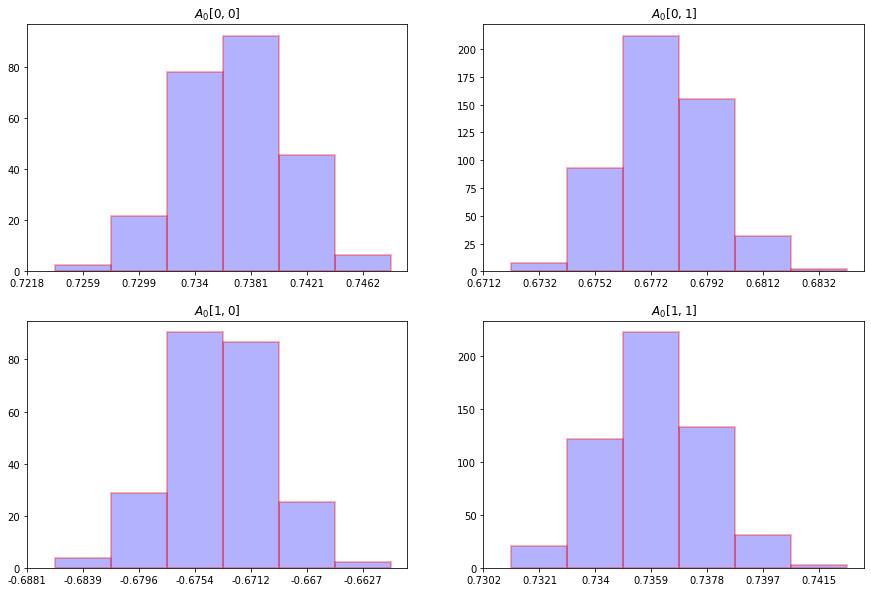

In [6]:
hist_AQ(A_inf, 0, 6, 'A')

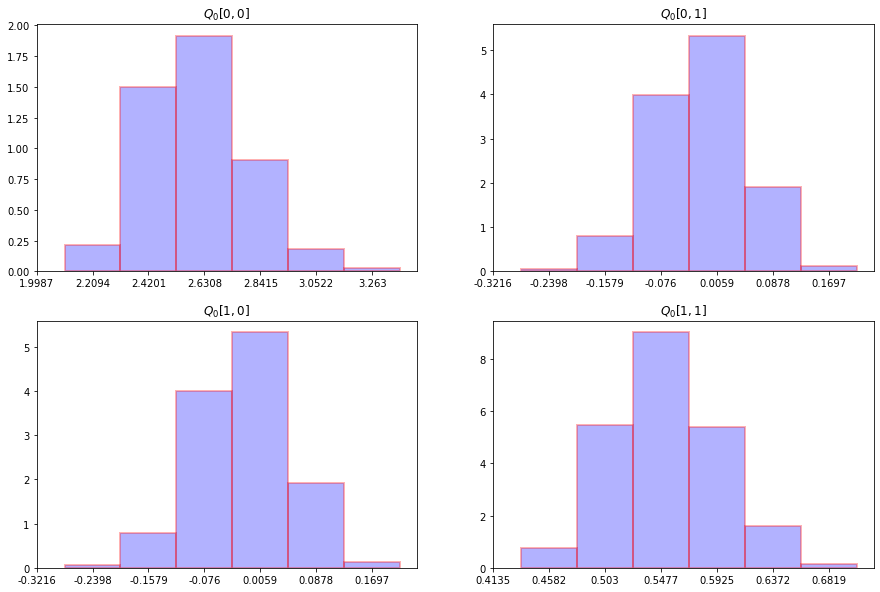

In [12]:
hist_AQ(Q_inf, 0, 6, 'Q')

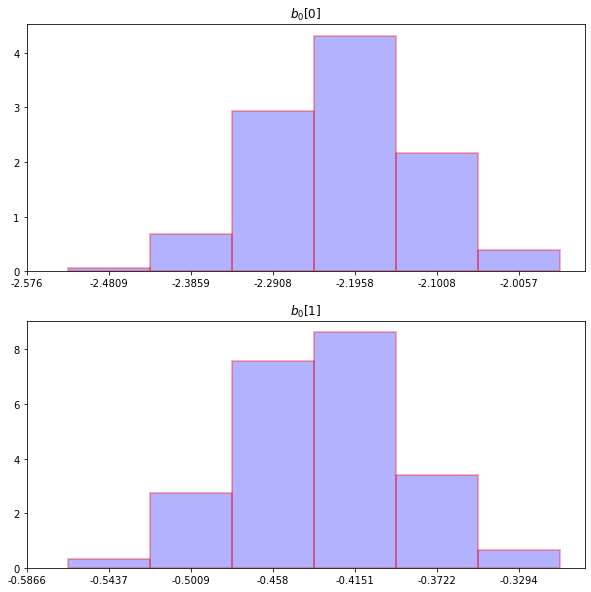

In [17]:
hist_b(b_inf, 0, 6)

## K = 1

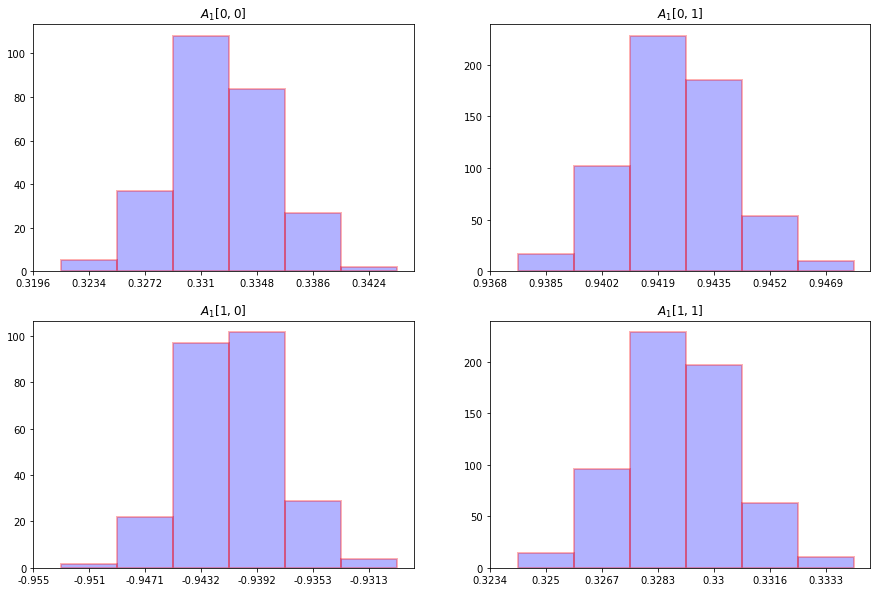

In [18]:
hist_AQ(A_inf, 1, 6, 'A')

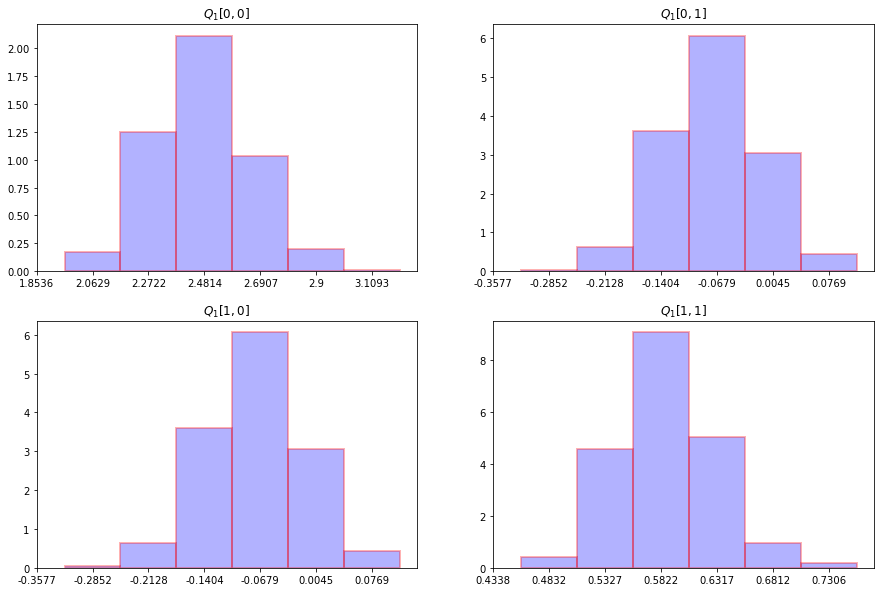

In [19]:
hist_AQ(Q_inf, 1, 6, 'Q')

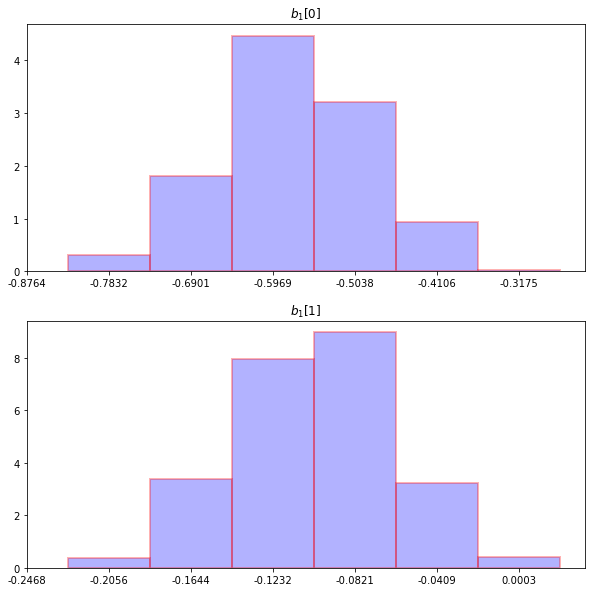

In [20]:
hist_b(b_inf, 1, 6)

## K = 2

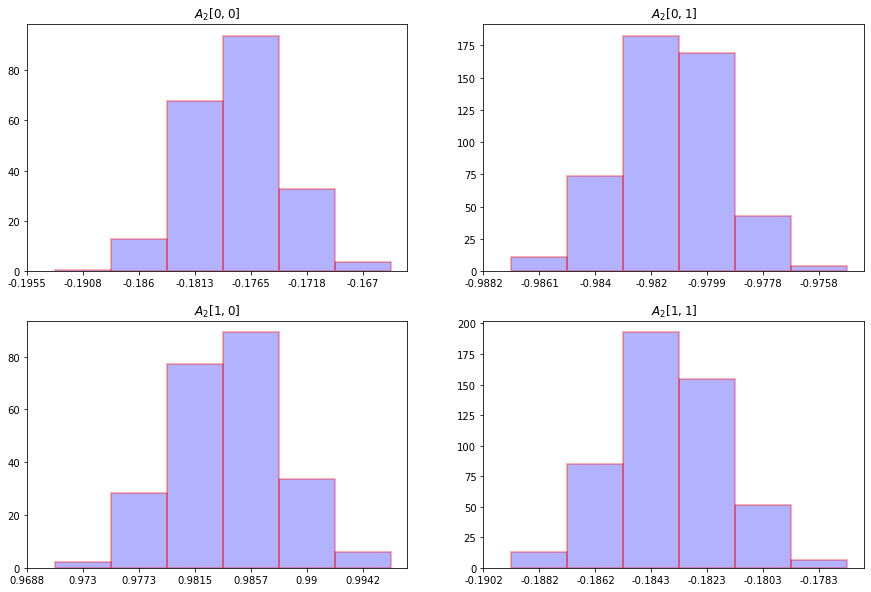

In [21]:
hist_AQ(A_inf, 2, 6, 'A')

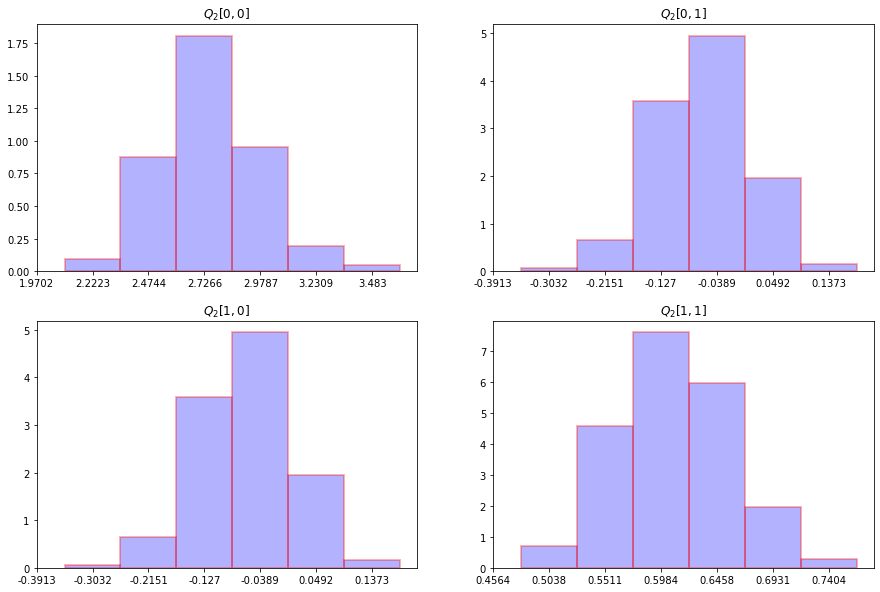

In [22]:
hist_AQ(Q_inf, 2, 6, 'Q')

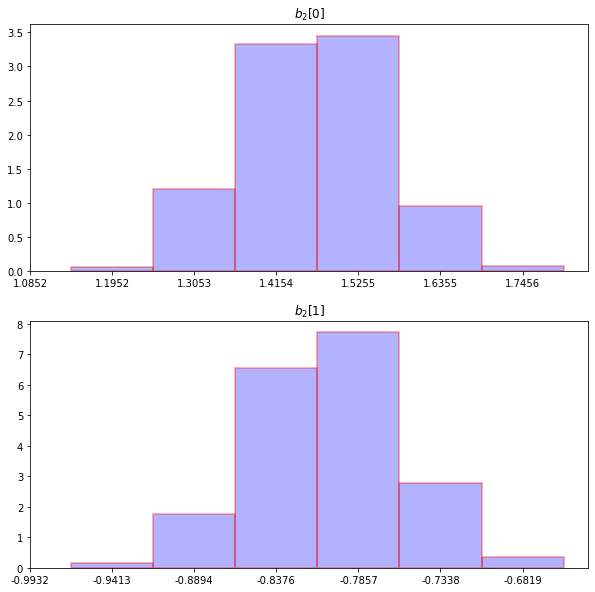

In [23]:
hist_b(b_inf, 2, 6)

## PI

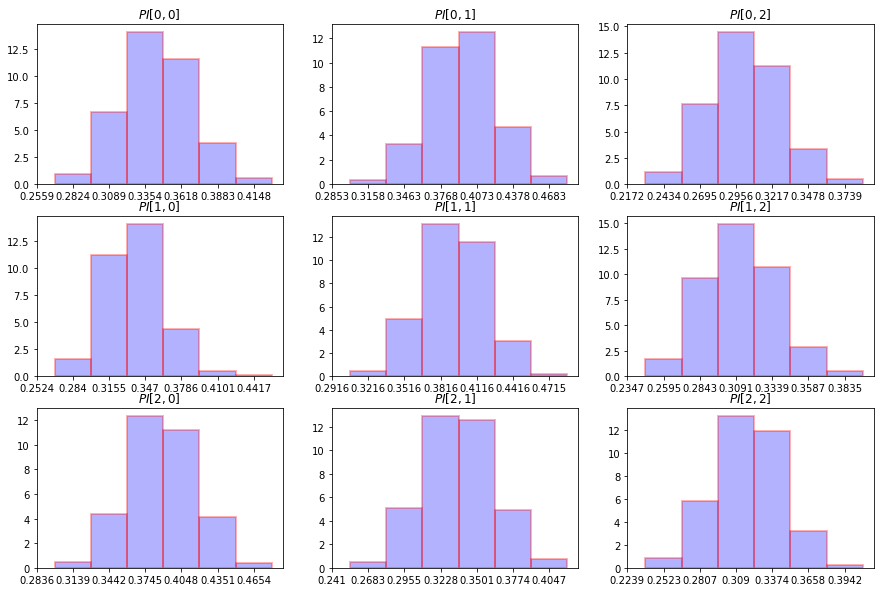

In [24]:
hist_PI(PI_inf,6)